In [26]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import datetime
import random
import tensorflow as tf
import math
import numpy as np
import os

In [ ]:
def make_result_reproducible(seed_value):

    # Set the `PYTHONHASHSEED` environment variable at a fixed value
    # import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = '' # Not letting GPU to perform calculations

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    # import random
    random.seed(seed_value)

    # For numpy
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # import tensorflow as tf
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)


def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    print(end_date)
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    print(df['time_bin'].dtype)
    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D') # doesn't allow for custom bins
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)
    grid_crime_df['day_of_week'] = grid_crime_df['occ_date'].dt.dayofweek

    grid_crime_df.drop(columns=['x_index','y_index'],axis=1, inplace =True)

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences




In [54]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")
cell_size = 600
aggregation_period = 14 # In days
seed_value = 1
# make_result_reproducible(seed_value)

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

train_crime_df['occ_date'] = pd.to_datetime(train_crime_df['occ_date'])
train_crime_df = train_crime_df[train_crime_df.occ_date.dt.date >= datetime.date(2012,3,7)]
grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)
hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)


sequence_length = 26 # looking over whole year data to capture seasonal trend


2017-03-14 00:00:00
datetime64[ns]
2017-06-14 00:00:00
datetime64[ns]
5.0


/tmp/ipykernel_103267/1030444054.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_103267/1030444054.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [55]:
# run only once
last_time_bin = train_hotspots_crime_counts_df.time_bin.max()
start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])



<Axes: xlabel='occ_date'>

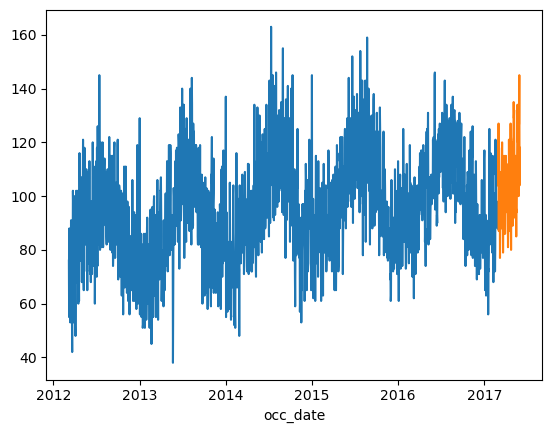

In [56]:
tr = train_crime_df.groupby(train_crime_df['occ_date'].dt.date).size()
test_crime_df['occ_date'] = pd.to_datetime(test_crime_df['occ_date'] )
ts = test_crime_df.groupby(test_crime_df['occ_date'].dt.date).size()
tr.plot()
ts.plot()



In [57]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_current = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bins_history.append(test_time_bins_current)

In [58]:

# test_time_bins = np.concatenate([test_time_bin_history, test_time_bins])

# Create every possible hotspot_cell-time_bin combination
grid_time_bin_train_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in train_time_bins],columns=['unique_id', 'time_bin'])
grid_time_bin_test_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in test_time_bins.sort_values()],columns=['unique_id', 'time_bin'])


In [59]:
# run only once
train_hotspots_crime_counts_df = grid_time_bin_train_df.merge(train_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)
test_hotspots_crime_counts_df = grid_time_bin_test_df.merge(test_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)
test_hotspots_crime_counts_df

,unique_id,time_bin,crime_count,hotspot
0,1290,2016-03-02,3.0,0.0
1,1290,2016-03-16,2.0,0.0
2,1290,2016-03-30,1.0,0.0
3,1290,2016-04-13,1.0,0.0
4,1290,2016-04-27,2.0,0.0
...,...,...,...,...
11545,11781,2017-03-29,2.0,0.0
11546,11781,2017-04-12,2.0,0.0
11547,11781,2017-04-26,5.0,1.0
11548,11781,2017-05-10,3.0,0.0


In [60]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

In [61]:

train_hotspots_crime_counts_df = train_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])

In [62]:
# Run only once

train_hotspots_crime_counts_df['month'] = train_hotspots_crime_counts_df.time_bin.dt.month
test_hotspots_crime_counts_df['month'] = test_hotspots_crime_counts_df.time_bin.dt.month

train_hotspots_crime_counts_df = pd.get_dummies(train_hotspots_crime_counts_df, columns=['month', ], dtype=int)
test_hotspots_crime_counts_df = pd.get_dummies(test_hotspots_crime_counts_df, columns=['month', ], dtype = int)


In [63]:
training_sequences = create_sequences(train_hotspots_crime_counts_df, seq_length=sequence_length)


In [64]:
training_sequences[0]

,unique_id,time_bin,crime_count,hotspot,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1290,2012-03-07,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1290,2012-03-21,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1290,2012-04-04,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1290,2012-04-18,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1290,2012-05-02,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,1290,2012-05-16,5.0,1,0,0,0,0,1,0,0,0,0,0,0,0
6,1290,2012-05-30,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,1290,2012-06-13,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,1290,2012-06-27,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,1290,2012-07-11,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [65]:
testing_sequences = create_sequences(test_hotspots_crime_counts_df, seq_length=sequence_length)

In [66]:
testing_sequences[0]

,unique_id,time_bin,crime_count,hotspot,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1290,2016-03-02,3.0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1290,2016-03-16,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1290,2016-03-30,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1290,2016-04-13,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1290,2016-04-27,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,1290,2016-05-11,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,1290,2016-05-25,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,1290,2016-06-08,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,1290,2016-06-22,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,1290,2016-07-06,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

positive_data = []
negative_data = []
for sequence in training_sequences:
    if sequence['hotspot'].iloc[-1] == 1:
        positive_data.append(sequence)
    else:
        negative_data.append(sequence)

print(len(positive_data))
negative_sample = resample(negative_data, replace=False,  n_samples=len(positive_data), random_state=seed_value) 

balanced_data = positive_data + negative_sample



train_data, val_data = train_test_split(balanced_data, test_size=0.1, random_state=seed_value)

test_data = testing_sequences
# # Split the remaining set into validation and test sets
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=1)

2271


In [68]:
features = train_data[0].columns[-12:]
['crime_count', *features]

['crime_count',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [69]:
def prepare_trainable_data(samples):
    X = []
    y = []
    for seq in samples:
        X_seq = seq[['crime_count', *features]].values  # Select features for X
        X.append(X_seq[:-1])  # Exclude the last time step from X
        y.append(seq['hotspot'].iloc[-1])  # Use the last time step's 'hotspot' value as y
    # return X, y
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_trainable_data(train_data)

# Prepare validation data
X_val, y_val = prepare_trainable_data(val_data)

# Prepare test data
X_test, y_test = prepare_trainable_data(test_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4087, 26, 13), (2450, 26, 13), (4087,), (2450,))

In [77]:
make_result_reproducible(seed_value)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=20))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate= 0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
X_train

array([[[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  1.,  0.,  0.],
        ...,
        [ 3.,  0.,  0., ...,  0.,  0.,  0.],
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 7.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 3.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 4.,  0.,  0., ...,  0.,  0.,  0.],
        [ 5.,  0.,  0., ...,  0.,  0.,  0.],
        [ 7.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  1.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  1., ...,  0.,  0.,  0.],
        [ 1.,  0.,  1., ...,  0.,  0.,  0.],
        ...,
        [ 2.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 1.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[10.,  0.,  0., ...,  0.,  0.,  0.],
        [10.,  0.,  0., ...,  0.,  0.,  0.],
        [ 6.,  0.,  0., ...,  0.,  0.,  0.

In [78]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, )

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7371 - loss: 0.6038 - val_accuracy: 0.8110 - val_loss: 0.4877
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8067 - loss: 0.4660 - val_accuracy: 0.8132 - val_loss: 0.4355
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8083 - loss: 0.4385 - val_accuracy: 0.8154 - val_loss: 0.4278
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8106 - loss: 0.4321 - val_accuracy: 0.8110 - val_loss: 0.4217
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8130 - loss: 0.4274 - val_accuracy: 0.8154 - val_loss: 0.4173
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8129 - loss: 0.4241 - val_accuracy: 0.8110 - val_loss: 0.4144
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8123 - loss: 0.4219 - val_accuracy: 0.8110 - val_loss: 0.4124
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8126 - loss: 0.4203 - val_accu

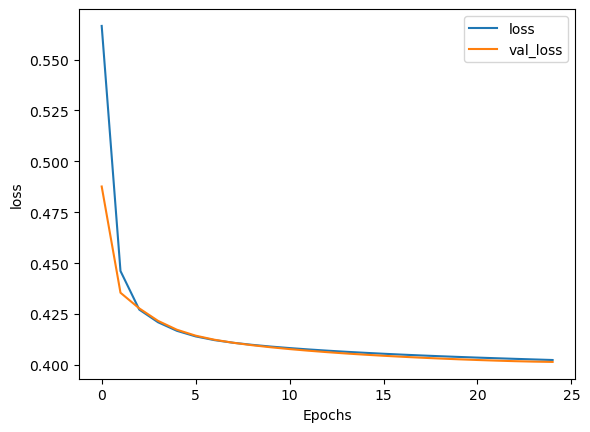

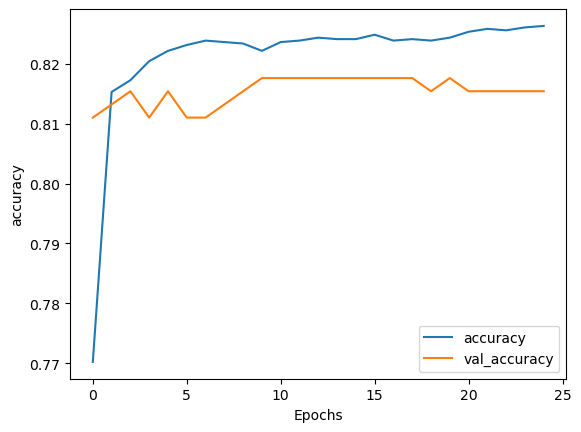

In [79]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
# plot_history(history, 'precision')
# plot_history(history, 'recall')


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the test data
# _, accuracy = model.evaluate(X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
# print(metrics)
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.9).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8094 - loss: 0.4073
Accuracy: 82.61
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Precision: 74.00
Recall: 47.74
F1-score: 58.04


In [ ]:
# # history l1= 50, l2 = 20

# 77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8468 - loss: 0.3697
# Accuracy: 85.92
# 77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
# Precision: 73.87
# Recall: 52.56
# F1-score: 61.42


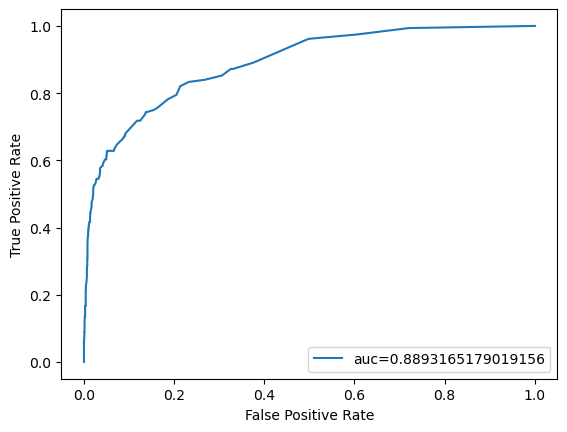

In [64]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [70]:
import datetime
crime_hotspots = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.time_bin.dt.date >= datetime.date(2017, 3, 1) ]

crime_hotspots.loc[:,'predicted'] = y_pred_binary
# crime_hotspots.to_csv('forecasted_result.csv')


/tmp/ipykernel_380926/852830955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_hotspots.loc[:,'predicted'] = y_pred_binary


In [71]:
cell_size = 600
grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

In [86]:
test_time_step_starting_dates = test_time_bins[-7:]
crime_hotspots_1st_week = crime_hotspots[crime_hotspots.time_bin.dt.date == test_time_step_starting_dates[0].date() ]

predicted_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].unique_id)
hotspot_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['hotspot'] == 1].unique_id)

total_crimes_in_predicted_hotspots = crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()
# # # x

In [87]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")
# pai


93.0
1381
3960000.0
4117743414.8055296
PAI = 70.02503996827696


In [88]:

test_crime_count_list = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count
desc_sorted = -np.sort(-np.array(test_crime_count_list))
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted[:number_of_cells].sum()

pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")

# grid['pre']
    
# # y_test
# test_crime_counts_df.crime_count.max()

PEI: 0.8942307692307693


In [89]:
len(predicted_grid_ids), len(hotspot_grid_ids), len(np.intersect1d(predicted_grid_ids, hotspot_grid_ids))

(11, 25, 11)

In [32]:
grid.loc[grid.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(hotspot_grid_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(predicted_grid_ids, hotspot_grid_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/crime-forecast-grid-mar-01-mar-14.shp")


### For 3 month period

In [90]:


all_predicted_hotspot_cell_ids =  crime_hotspots[crime_hotspots.predicted == 1].unique_id.unique()
all_hotspot_cell_ids =  crime_hotspots[crime_hotspots.hotspot == 1].unique_id.unique()


total_crimes_in_predicted_hotspots = crime_hotspots[crime_hotspots['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date >= test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(all_predicted_hotspot_cell_ids)].area.sum()
total_area = grid.area.sum()

np.intersect1d(all_hotspot_cell_ids, all_predicted_hotspot_cell_ids)

array([ 4348,  4460,  4576,  4692,  4693,  4809,  4924,  5040,  5041,
        5042,  5043,  5044,  5155,  5156,  5157,  5270,  5271,  6074,
        8653, 10156, 11441, 11516, 11517])

In [91]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)

pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")


763.0
9553
8245351.739489673
4117743414.8055296
PAI = 39.88731974096387


In [ ]:
# 763.0
# 9553
# 7165351.739489673
# 4117743414.8055296
# PAI = 45.89934914111569

In [92]:


desc_sorted_test_crime_count_list = test_crime_counts_df.groupby('unique_id').agg({'crime_count': lambda x: sum(x)}).crime_count.sort_values(ascending=False)
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
# print(number_of_cells)
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted_test_crime_count_list[:number_of_cells].sum()
# print(desc_sorted)
pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")
print(total_crimes_in_predicted_hotspots)
print(maximum_obtainable_crimes_for_the_forecasted_area)



PEI: 0.763
763.0
1000


In [36]:
grid.loc[grid.unique_id.isin(all_predicted_hotspot_cell_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(all_hotspot_cell_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(all_predicted_hotspot_cell_ids, all_hotspot_cell_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/crime-forecast-grid-mar-01-may-31.shp")


# OLD extra


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
def create_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Create a KerasClassifier
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameter grid
param_grid = {
    'model__units': [20, 50, 80],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 40]
}

# Create a GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)  # 3-fold cross-validation

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/20


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7290 - loss: 0.5584
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7621 - loss: 0.5085
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7804 - loss: 0.4726
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7678 - loss: 0.4830
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7559 - loss: 0.5091
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7789 - loss: 0.4784
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7880 - loss: 0.4844
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7998 - loss: 0.4536
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7719 - loss: 0.4841
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7753 - loss: 0.4778
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7778 - loss: 0.4752
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7489 - loss: 0.5371
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7708 - loss: 0.4948
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7897 - loss: 0.4699
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7820 - loss: 0.4930
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7896 - loss: 0.4689
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7774 - loss: 0.4898
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8048 - loss: 0.4491
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7826 - loss: 0.4821
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7910 - loss: 0.4627
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7967 - loss: 0.4679
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7977 - loss: 0.4525
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7315 - loss: 0.5298
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7964 - loss: 0.4615
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7940 - loss: 0.4578
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7712 - loss: 0.4890
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7753 - loss: 0.4732
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7999 - loss: 0.4490
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7998 - loss: 0.4475
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7899 - loss: 0.4392
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8146 - loss: 0.4348
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7894 - loss: 0.4452
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8005 - loss: 0.4563
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7422 - loss: 0.5464
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7772 - loss: 0.4938
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7594 - loss: 0.5081
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7722 - loss: 0.4851
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7665 - loss: 0.4902
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7709 - loss: 0.4824
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7519 - loss: 0.5089
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7722 - loss: 0.4707
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7641 - loss: 0.4807
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7811 - loss: 0.4680
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7869 - loss: 0.4724
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7399 - loss: 0.5391
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8020 - loss: 0.4711
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7740 - loss: 0.4806
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7807 - loss: 0.4843
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7827 - loss: 0.4772
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7644 - loss: 0.4873
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7893 - loss: 0.4758
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7721 - loss: 0.4940
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7983 - loss: 0.4645
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7952 - loss: 0.4627
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7850 - loss: 0.4748
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7652 - loss: 0.5256
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7844 - loss: 0.4822
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7903 - loss: 0.4649
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7974 - loss: 0.4566
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7975 - loss: 0.4502
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7994 - loss: 0.4547
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7784 - loss: 0.4640
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7837 - loss: 0.4691
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7837 - loss: 0.4635
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7988 - loss: 0.4464
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8090 - loss: 0.4403
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7194 - loss: 0.5630
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7648 - loss: 0.4954
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7727 - loss: 0.4979
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7781 - loss: 0.4800
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7788 - loss: 0.4892
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7710 - loss: 0.4950
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7807 - loss: 0.4817
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7637 - loss: 0.4989
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7825 - loss: 0.4698
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7827 - loss: 0.4742
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7747 - loss: 0.4705
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7179 - loss: 0.5793
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7915 - loss: 0.4928
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7800 - loss: 0.4823
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7850 - loss: 0.4736
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8004 - loss: 0.4555
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7907 - loss: 0.4711
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7808 - loss: 0.4698
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7977 - loss: 0.4644
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7776 - loss: 0.4709
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7953 - loss: 0.4600
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7944 - loss: 0.4655
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7372 - loss: 0.5780
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7979 - loss: 0.4584
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7904 - loss: 0.4647
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7826 - loss: 0.4707
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8035 - loss: 0.4620
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8006 - loss: 0.4568
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8073 - loss: 0.4401
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7958 - loss: 0.4468
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7816 - loss: 0.4657
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7839 - loss: 0.4653
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7850 - loss: 0.4622
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7429 - loss: 0.5703
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7744 - loss: 0.4922
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7777 - loss: 0.4859
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7676 - loss: 0.4903
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7742 - loss: 0.4830
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7828 - loss: 0.4746
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7712 - loss: 0.4911
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7749 - loss: 0.4853
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7671 - loss: 0.4841
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7794 - loss: 0.4681
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7801 - loss: 0.4677
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6760 - loss: 0.5871
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7911 - loss: 0.4715
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7958 - loss: 0.4675
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7948 - loss: 0.4706
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7893 - loss: 0.4813
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7857 - loss: 0.4777
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7726 - loss: 0.4849
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8039 - loss: 0.4424
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7901 - loss: 0.4703
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7944 - loss: 0.4562
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7846 - loss: 0.4754
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7279 - loss: 0.5579
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7807 - loss: 0.4708
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8006 - loss: 0.4510
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7948 - loss: 0.4650
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7932 - loss: 0.4503
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7990 - loss: 0.4449
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7883 - loss: 0.4534
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7859 - loss: 0.4786
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8008 - loss: 0.4460
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8073 - loss: 0.4428
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7949 - loss: 0.4528
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7127 - loss: 0.5576
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7673 - loss: 0.5001
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7811 - loss: 0.4799
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7758 - loss: 0.4848
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7550 - loss: 0.5056
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7862 - loss: 0.4727
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7741 - loss: 0.4790
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7670 - loss: 0.4928
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7767 - loss: 0.4808
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7804 - loss: 0.4826
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7840 - loss: 0.4783
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7258 - loss: 0.5474
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7874 - loss: 0.4664
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7623 - loss: 0.4979
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7872 - loss: 0.4737
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7939 - loss: 0.4711
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7939 - loss: 0.4781
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7919 - loss: 0.4610
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7865 - loss: 0.4838
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8050 - loss: 0.4540
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7986 - loss: 0.4565
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7989 - loss: 0.4523
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7080 - loss: 0.5380
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7942 - loss: 0.4658
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7720 - loss: 0.4750
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7870 - loss: 0.4593
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7977 - loss: 0.4511
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7778 - loss: 0.4674
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7947 - loss: 0.4516
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7918 - loss: 0.4531
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7970 - loss: 0.4468
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8047 - loss: 0.4393
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7901 - loss: 0.4594
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7011 - loss: 0.5585
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7651 - loss: 0.4916
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7674 - loss: 0.4841
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7751 - loss: 0.4876
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7771 - loss: 0.4874
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7778 - loss: 0.4753
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7808 - loss: 0.4768
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7810 - loss: 0.4667
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7751 - loss: 0.4854
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7726 - loss: 0.4856
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7733 - loss: 0.4827
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7319 - loss: 0.5305
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7701 - loss: 0.4911
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7784 - loss: 0.4848
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8064 - loss: 0.4437
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7989 - loss: 0.4670
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8071 - loss: 0.4480
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7903 - loss: 0.4697
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7940 - loss: 0.4727
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7934 - loss: 0.4647
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7882 - loss: 0.4697
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7935 - loss: 0.4609
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7010 - loss: 0.5526
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7877 - loss: 0.4663
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7927 - loss: 0.4511
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7760 - loss: 0.4848
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7858 - loss: 0.4712
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7981 - loss: 0.4434
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7859 - loss: 0.4515
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7809 - loss: 0.4754
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7981 - loss: 0.4476
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7983 - loss: 0.4616
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7999 - loss: 0.4470
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5116 - loss: 0.6787
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7604 - loss: 0.5869
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7911 - loss: 0.4859
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7603 - loss: 0.5086
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7737 - loss: 0.4914
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7686 - loss: 0.4898
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7605 - loss: 0.5018
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7707 - loss: 0.4838
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7656 - loss: 0.4867
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7636 - loss: 0.4968
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7731 - loss: 0.4853
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4060 - loss: 0.7413
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7648 - loss: 0.6607
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7611 - loss: 0.5430
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7800 - loss: 0.4912
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7890 - loss: 0.4745
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7749 - loss: 0.4899
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7616 - loss: 0.4957
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7863 - loss: 0.4677
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7905 - loss: 0.4589
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7757 - loss: 0.4762
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7812 - loss: 0.4786
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5306 - loss: 0.6720
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7842 - loss: 0.5845
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7791 - loss: 0.4950
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7711 - loss: 0.4860
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7789 - loss: 0.4728
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7766 - loss: 0.4793
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7722 - loss: 0.4757
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8054 - loss: 0.4449
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7886 - loss: 0.4620
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7808 - loss: 0.4671
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7725 - loss: 0.4752
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6656 - loss: 0.6522
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7638 - loss: 0.5043
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7753 - loss: 0.4823
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7620 - loss: 0.5044
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7774 - loss: 0.4882
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7861 - loss: 0.4677
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7710 - loss: 0.4840
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7901 - loss: 0.4784
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7713 - loss: 0.4841
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7815 - loss: 0.4704
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7760 - loss: 0.4719
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5669 - loss: 0.6654
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7675 - loss: 0.5027
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7748 - loss: 0.4850
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7843 - loss: 0.4835
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7711 - loss: 0.4884
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7939 - loss: 0.4750
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7883 - loss: 0.4625
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7783 - loss: 0.4907
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7836 - loss: 0.4714
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7789 - loss: 0.4812
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7703 - loss: 0.4932
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6240 - loss: 0.6584
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7828 - loss: 0.4815
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7868 - loss: 0.4664
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7808 - loss: 0.4741
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7842 - loss: 0.4782
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7757 - loss: 0.4683
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7883 - loss: 0.4642
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7837 - loss: 0.4705
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8001 - loss: 0.4517
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7926 - loss: 0.4625
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7819 - loss: 0.4611
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6697 - loss: 0.6085
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7686 - loss: 0.4973
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7684 - loss: 0.4921
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7584 - loss: 0.4938
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7734 - loss: 0.4759
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7659 - loss: 0.4914
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7677 - loss: 0.4897
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7642 - loss: 0.4998
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7783 - loss: 0.4739
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7705 - loss: 0.4829
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7857 - loss: 0.4662
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5941 - loss: 0.6272
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7815 - loss: 0.4775
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7825 - loss: 0.4757
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7758 - loss: 0.4786
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7740 - loss: 0.4879
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7756 - loss: 0.4876
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7734 - loss: 0.4886
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7802 - loss: 0.4766
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7920 - loss: 0.4598
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8010 - loss: 0.4575
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7809 - loss: 0.4665
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6401 - loss: 0.6096
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7983 - loss: 0.4517
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7745 - loss: 0.4803
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7933 - loss: 0.4607
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7884 - loss: 0.4643
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7924 - loss: 0.4527
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7985 - loss: 0.4537
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7852 - loss: 0.4587
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7877 - loss: 0.4490
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7821 - loss: 0.4655
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7904 - loss: 0.4585
Epoch 12/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6885 - loss: 0.5751
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7646 - loss: 0.5055
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7710 - loss: 0.4900
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7736 - loss: 0.4806
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7785 - loss: 0.4814
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7663 - loss: 0.4822
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7780 - loss: 0.4771
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7737 - loss: 0.4916
Epoch 9/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7622 - loss: 0.4824
Epoch 10/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7618 - loss: 0.4881
Epoch 11/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7776 - loss: 0.4759
Epoch 12/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7457 - loss: 0.5329
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7791 - loss: 0.4934
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7818 - loss: 0.4809
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7607 - loss: 0.5111
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7899 - loss: 0.4597
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7920 - loss: 0.4618
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7824 - loss: 0.4739
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7994 - loss: 0.4567
Epoch 9/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8010 - loss: 0.4648
Epoch 10/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7859 - loss: 0.4766
Epoch 11/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7852 - loss: 0.4702
Epoch 12/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7469 - loss: 0.5168
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7733 - loss: 0.4897
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7946 - loss: 0.4536
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7872 - loss: 0.4572
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7891 - loss: 0.4610
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7785 - loss: 0.4728
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8060 - loss: 0.4444
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7887 - loss: 0.4516
Epoch 9/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8066 - loss: 0.4421
Epoch 10/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7997 - loss: 0.4525
Epoch 11/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7993 - loss: 0.4423
Epoch 12/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7186 - loss: 0.5416
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7757 - loss: 0.4929
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7853 - loss: 0.4843
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7569 - loss: 0.5001
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7707 - loss: 0.4769
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7748 - loss: 0.4790
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7580 - loss: 0.5051
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7728 - loss: 0.4945
Epoch 9/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7763 - loss: 0.4773
Epoch 10/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7841 - loss: 0.4744
Epoch 11/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7585 - loss: 0.4860
Epoch 12/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/ste

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7451 - loss: 0.5233
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7782 - loss: 0.4933
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7891 - loss: 0.4713
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7692 - loss: 0.4941
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7998 - loss: 0.4702
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7847 - loss: 0.4693
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8032 - loss: 0.4558
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7799 - loss: 0.4761
Epoch 9/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7902 - loss: 0.4790
Epoch 10/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7948 - loss: 0.4709
Epoch 11/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7954 - loss: 0.4559
Epoch 12/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/ste